# Import

In [6]:
import logging
from typing import Tuple, Dict, Any
from typing_extensions import Annotated
#from haversine import haversine, Unit

#import pandas as pd
import numpy as np

import os
import requests
import json
import time

from pathlib import Path
import calendar
import holidays
from datetime import date, timedelta



from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

import optuna        # HPO
import mlflow        # Tracking
from mlflow.models import infer_signature

import matplotlib.pyplot as plt
import seaborn as sns
from  matplotlib.lines import Line2D

from bokeh.plotting import figure, show
from bokeh.io import output_notebook

In [2]:
#from dotenv import load_dotenv
#dotenv_path = Path('../.env')
#load_dotenv(dotenv_path=dotenv_path)

# Dataset

### Train data

In [2]:
# Train directory
train_year = 2024
src_train_data_path = f"data/final/{train_year}"
src_train_data_path

'data/final/2024'

In [3]:
# Read train trips data

train_trips_file = f"{train_year}-citibike-tripdata.parquet"
train_trips_path = os.path.join(src_train_data_path, train_trips_file)
train_trips_data = pd.read_parquet(train_trips_path)

In [4]:
train_trips_data.shape

(8795, 4)

In [5]:
train_trips_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8795 entries, 0 to 8794
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     8795 non-null   datetime64[ns]
 1   hour     8795 non-null   int32         
 2   trips    8795 non-null   int64         
 3   holiday  8795 non-null   int64         
dtypes: datetime64[ns](1), int32(1), int64(2)
memory usage: 240.6 KB


In [6]:
train_trips_data[train_trips_data['date'] >= '2023-12-31'].head(5)
#train_trips_data.head(5)

,date,hour,trips,holiday
0,2023-12-31,23,278,0
1,2024-01-01,0,1863,1
2,2024-01-01,1,2291,1
3,2024-01-01,2,1903,1
4,2024-01-01,3,1081,1


In [7]:
train_trips_data[train_trips_data['date'] > '2024-12-31']

,date,hour,trips,holiday


In [8]:
train_trips_data.head(5)

,date,hour,trips,holiday
0,2023-12-31,23,278,0
1,2024-01-01,0,1863,1
2,2024-01-01,1,2291,1
3,2024-01-01,2,1903,1
4,2024-01-01,3,1081,1


In [9]:
# Read train wwather data

train_weather_data_file = f"{train_year}-weather.parquet"
train_weather_data_path = os.path.join(src_train_data_path, train_weather_data_file)
train_weather_data = pd.read_parquet(train_weather_data_path)

In [10]:
train_weather_data.shape

(366, 8)

In [11]:
train_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    366 non-null    datetime64[ns]
 1   AWND    366 non-null    float64       
 2   PRCP    366 non-null    float64       
 3   SNOW    366 non-null    float64       
 4   SNWD    366 non-null    float64       
 5   TAVG    366 non-null    float64       
 6   TMAX    366 non-null    float64       
 7   TMIN    366 non-null    float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 23.0 KB


In [12]:
train_weather_data.head(5)

,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN
0,2024-01-01,6.7,0.01,0.0,0.0,43.0,47.0,36.0
1,2024-01-02,9.4,0.00,0.0,0.0,37.0,43.0,30.0
2,2024-01-03,9.2,0.00,0.0,0.0,39.0,43.0,35.0
3,2024-01-04,15.0,0.00,0.0,0.0,41.0,45.0,29.0
4,2024-01-05,11.9,0.00,0.0,0.0,32.0,38.0,27.0


## Test data

In [13]:
# Test directory
test_year = 2025
src_test_data_path = f"data/final/{test_year}"
src_test_data_path

'data/final/2025'

In [14]:
# Read test trips data

test_trips_file = f"{test_year}-citibike-tripdata.parquet"
test_trips_path = os.path.join(src_test_data_path, test_trips_file)
test_trips_data = pd.read_parquet(test_trips_path)

In [15]:
test_trips_data.shape

(2162, 4)

In [16]:
test_trips_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2162 entries, 0 to 2161
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     2162 non-null   datetime64[ns]
 1   hour     2162 non-null   int32         
 2   trips    2162 non-null   int64         
 3   holiday  2162 non-null   int64         
dtypes: datetime64[ns](1), int32(1), int64(2)
memory usage: 59.2 KB


In [17]:
test_trips_data.head(5)

,date,hour,trips,holiday
0,2024-12-31,23,162,0
1,2025-01-01,0,1585,1
2,2025-01-01,1,2682,1
3,2025-01-01,2,2263,1
4,2025-01-01,3,1326,1


In [18]:
# Read test wwather data

test_weather_data_file = f"{test_year}-weather.parquet"
test_weather_data_path = os.path.join(src_test_data_path, test_weather_data_file)
test_weather_data = pd.read_parquet(test_weather_data_path)

In [19]:
test_weather_data.shape

(88, 8)

In [20]:
test_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    88 non-null     datetime64[ns]
 1   AWND    88 non-null     float64       
 2   PRCP    88 non-null     float64       
 3   SNOW    88 non-null     float64       
 4   SNWD    88 non-null     float64       
 5   TAVG    88 non-null     float64       
 6   TMAX    88 non-null     float64       
 7   TMIN    88 non-null     float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 5.6 KB


In [21]:
test_weather_data.head(5)

,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN
0,2025-01-01,16.1,0.0,0.0,0.0,47.0,52.0,40.0
1,2025-01-02,20.4,0.0,0.0,0.0,41.0,44.0,35.0
2,2025-01-03,14.3,0.0,0.0,0.0,36.0,40.0,32.0
3,2025-01-04,22.1,0.0,0.0,0.0,33.0,34.0,29.0
4,2025-01-05,16.6,0.0,0.0,0.0,30.0,34.0,28.0


# Feature Engineering

In [22]:
def preprocess_data(
    df: pd.DataFrame
) -> pd.DataFrame:

    data = df.copy()
    
    # Create hout of day
    #data['hr'] = data['date'].dt.hour
    
    # Create day of the week feature
    data['weekday'] = data['date'].dt.dayofweek

    # Create day of the year feature
    data["day"] = data["date"].dt.day

    # Create day of the year feature
    data['week_num'] = data['date'].dt.isocalendar().week

    # Create month number column
    data['mnth'] = data['date'].dt.month
    
    # Create year column
    data['year'] =data['date'].dt.year
    
    # New Features
    #data['hr_sin'] = np.sin(data.hr * (2.*np.pi/24))
    #data['hr_cos'] = np.cos(data.hr * (2.*np.pi/24))
    data['hr_sin'] = np.sin(data.hour * (2.*np.pi/24))
    data['hr_cos'] = np.cos(data.hour * (2.*np.pi/24))
    data['weekday_sin'] = np.sin(data.weekday * (2.*np.pi/7))
    data['weekday_cos'] = np.cos(data.weekday * (2.*np.pi/7))
    data['week_sin'] = np.sin(2 * np.pi * (data.week_num-1) / 52)
    data['week_cos'] = np.cos(2 * np.pi * (data.week_num-1) / 52)
    data['mnth_sin'] = np.sin((data.mnth - 1) * (2.*np.pi/12))
    data['mnth_cos'] = np.cos((data.mnth - 1) * (2.*np.pi/12))
    data['day_sin'] = np.sin((data.day - 1) * (2.*np.pi/366))
    data['day_cos'] = np.cos((data.day - 1) * (2.*np.pi/366))
    

    # drop 'Start Station Name' y 'End Station Name' colums
    # Drop columns
    drop_columns = [
        'date', 'hour',
        #'hr', 
        'weekday', 'mnth', 'week_num', 'day',
        'DATE', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 
    ]
    data = data.drop(columns=drop_columns)

    return data

##  Train data

In [23]:
# Train data
train_trips_modeling_data = train_trips_data.merge(train_weather_data, how='inner', left_on='date', right_on='DATE')

In [24]:
# Compare shape data
train_trips_modeling_data.shape, train_trips_data.shape

((8794, 12), (8795, 4))

In [25]:
# Show sample data
train_trips_modeling_data.head(5)

,date,hour,trips,holiday,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN
0,2024-01-01,0,1863,1,2024-01-01,6.7,0.01,0.0,0.0,43.0,47.0,36.0
1,2024-01-01,1,2291,1,2024-01-01,6.7,0.01,0.0,0.0,43.0,47.0,36.0
2,2024-01-01,2,1903,1,2024-01-01,6.7,0.01,0.0,0.0,43.0,47.0,36.0
3,2024-01-01,3,1081,1,2024-01-01,6.7,0.01,0.0,0.0,43.0,47.0,36.0
4,2024-01-01,4,636,1,2024-01-01,6.7,0.01,0.0,0.0,43.0,47.0,36.0


In [26]:
# Feature engineering
train_trips_modeling_feats = preprocess_data(
    train_trips_modeling_data
)

In [27]:
train_trips_modeling_feats.shape

(8794, 15)

In [28]:
train_trips_modeling_feats.head(5)

,trips,holiday,TMAX,TMIN,year,hr_sin,hr_cos,weekday_sin,weekday_cos,week_sin,week_cos,mnth_sin,mnth_cos,day_sin,day_cos
0,1863,1,47.0,36.0,2024,0.000000,1.000000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,2291,1,47.0,36.0,2024,0.258819,0.965926,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2,1903,1,47.0,36.0,2024,0.500000,0.866025,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3,1081,1,47.0,36.0,2024,0.707107,0.707107,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,636,1,47.0,36.0,2024,0.866025,0.500000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


## Test data

Merge trips and weather data

In [29]:
# Train data
test_trips_modeling_data = test_trips_data.merge(test_weather_data, how='inner', left_on='date', right_on='DATE')

In [30]:
test_trips_modeling_data.shape, test_trips_data.shape

((2113, 12), (2162, 4))

In [31]:
test_trips_modeling_data.head(5)

,date,hour,trips,holiday,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN
0,2025-01-01,0,1585,1,2025-01-01,16.1,0.0,0.0,0.0,47.0,52.0,40.0
1,2025-01-01,1,2682,1,2025-01-01,16.1,0.0,0.0,0.0,47.0,52.0,40.0
2,2025-01-01,2,2263,1,2025-01-01,16.1,0.0,0.0,0.0,47.0,52.0,40.0
3,2025-01-01,3,1326,1,2025-01-01,16.1,0.0,0.0,0.0,47.0,52.0,40.0
4,2025-01-01,4,754,1,2025-01-01,16.1,0.0,0.0,0.0,47.0,52.0,40.0


In [32]:
# Feature engineering
test_trips_modeling_feats = preprocess_data(
    test_trips_modeling_data
)

In [33]:
test_trips_modeling_feats.shape

(2113, 15)

In [34]:
test_trips_modeling_feats.head(5)

,trips,holiday,TMAX,TMIN,year,hr_sin,hr_cos,weekday_sin,weekday_cos,week_sin,week_cos,mnth_sin,mnth_cos,day_sin,day_cos
0,1585,1,52.0,40.0,2025,0.000000,1.000000,0.974928,-0.222521,0.0,1.0,0.0,1.0,0.0,1.0
1,2682,1,52.0,40.0,2025,0.258819,0.965926,0.974928,-0.222521,0.0,1.0,0.0,1.0,0.0,1.0
2,2263,1,52.0,40.0,2025,0.500000,0.866025,0.974928,-0.222521,0.0,1.0,0.0,1.0,0.0,1.0
3,1326,1,52.0,40.0,2025,0.707107,0.707107,0.974928,-0.222521,0.0,1.0,0.0,1.0,0.0,1.0
4,754,1,52.0,40.0,2025,0.866025,0.500000,0.974928,-0.222521,0.0,1.0,0.0,1.0,0.0,1.0


In [35]:
df = pd.concat([train_trips_data, test_trips_data], ignore_index=True)

In [36]:
df.shape

(10957, 4)

In [37]:
df.head(5)

,date,hour,trips,holiday
0,2023-12-31,23,278,0
1,2024-01-01,0,1863,1
2,2024-01-01,1,2291,1
3,2024-01-01,2,1903,1
4,2024-01-01,3,1081,1


In [38]:
df.tail(5)

,date,hour,trips,holiday
10952,2025-03-31,19,5963,0
10953,2025-03-31,20,4289,0
10954,2025-03-31,21,1577,0
10955,2025-03-31,22,532,0
10956,2025-03-31,23,404,0


In [39]:
df[df["date"] >= "2025-01-01"]

,date,hour,trips,holiday
8796,2025-01-01,0,1585,1
8797,2025-01-01,1,2682,1
8798,2025-01-01,2,2263,1
8799,2025-01-01,3,1326,1
8800,2025-01-01,4,754,1
...,...,...,...,...
10952,2025-03-31,19,5963,0
10953,2025-03-31,20,4289,0
10954,2025-03-31,21,1577,0
10955,2025-03-31,22,532,0


# Feature Importance

In [40]:
def feature_importance_xgb(
    train_df, 
    target_column,
    num_feats, 
    ordinal_cat_feats, 
    target_cat_feats,
    params=None
):
    """Calculates feature importance using XGBoost."""
    #X = train_df.drop(columns=[target_column])
    print(f"[TRAIN] Ordinal_cat_feats: {ordinal_cat_feats}")
    print(f"[TRAIN] Target_cat_feats : {target_cat_feats}")
    print(f"[TRAIN] num_feats        : {num_feats}")
    feats = num_feats + target_cat_feats + ordinal_cat_feats
    X_train = train_df[feats]
    y_train = train_df[target_column]

    if not params:
        params = {
            'objective': 'reg:squarederror',
            #'tree_method': 'hist',
            '_estimators': 100,
            'random_state': 42
        }

    enc = make_column_transformer(
        #(StandardScaler(), numerical_features),
        ('passthrough', num_feats),
        (TargetEncoder(), target_cat_feats),
        (OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
         ordinal_cat_feats),
        remainder="passthrough",
        verbose_feature_names_out=True,
    )
    feature_types = ["c" if fn in ordinal_cat_feats else "q" 
                     for fn in X_train.columns]

    print(f"[TRAIN] Params: {params}")
    print(f"[TRAIN] feature_types: {feature_types}")
    # Detecta la GPU
    gpu_id = detect_gpu()
    if gpu_id >= 0:
        print(f"Detected GPU, using GPU {gpu_id}.")
        params['device'] = 'cuda'
    else:
        print("No GPU detected, using CPU.")
        params['device'] = 'cpu'
        
    reg = xgb.XGBRegressor(
        **params, 
        feature_types=feature_types,
        enable_categorical=True
    )
    #pipeline = make_pipeline(enc, reg)
    pipeline = make_pipeline(enc, reg)    
    pipeline.fit(X_train, y_train)
    #model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    #pipeline = build_pipeline(model, categorical_features, numerical_features)
    #pipeline.fit(X, y)
    #importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    # check XGBoost is using the feature type correctly.
    model_types = reg.get_booster().feature_types
    assert model_types is not None
    for a, b in zip(model_types, feature_types):
        assert a == b
    '''
    xgb_model = pipeline.named_steps['xgbregressor'] 
    preprocessor = pipeline.named_steps['preprocessor']]
    importance = pd.Series(
        xgb_model.feature_importances_, 
        index=preprocessor.get_feature_names_out()
    ).sort_values(ascending=False)
    #plot_feature_importance(importance, "XGBoost Feature Importance")
    return importance
    '''
    return pipeline

In [41]:
def run_rf_model(df, target_column='trips', standardize=False):
    """
    Train an XGBoost model on the given dataset and return the results.
    
    Parameters:
    - df: DataFrame containing the dataset
    - target_column: the name of the column to predict (default is 'trips')
    - standardize: whether to apply StandardScaler to features (default is False)
    
    Returns:
    - MSE: mean squared error of the model on the test set
    - importance_df: DataFrame containing feature importances
    """
    
    # Define features (X) and target (y)
    X = df.drop(columns=[target_column])  # Features
    y = df[target_column]  # Target
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Apply StandardScaler if specified
    if standardize:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    # Create and train the XGBoost model
    #model = xgb.XGBRegressor(n_estimators=100, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error (MSE): {mse}")
    
    # Get feature importances
    feature_importances = model.feature_importances_
    
    # Create a DataFrame for feature importances
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    })
    
    # Sort the features by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    # Visualize feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title(f'Feature Importance with XGBoost ({"Standardized" if standardize else "Original"})')
    plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
    plt.show()
    
    # Return the MSE and the feature importances DataFrame
    return mse, importance_df

In [42]:
def run_xgboost_model(df, target_column='trips', standardize=False):
    """
    Train an XGBoost model on the given dataset and return the results.
    
    Parameters:
    - df: DataFrame containing the dataset
    - target_column: the name of the column to predict (default is 'trips')
    - standardize: whether to apply StandardScaler to features (default is False)
    
    Returns:
    - MSE: mean squared error of the model on the test set
    - importance_df: DataFrame containing feature importances
    """
    
    # Define features (X) and target (y)
    X = df.drop(columns=[target_column])  # Features
    y = df[target_column]  # Target
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Apply StandardScaler if specified
    if standardize:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    # Create and train the XGBoost model
    model = xgb.XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error (MSE): {mse}")
    
    # Get feature importances
    feature_importances = model.feature_importances_
    
    # Create a DataFrame for feature importances
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    })
    
    # Sort the features by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    # Visualize feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title(f'Feature Importance with XGBoost ({"Standardized" if standardize else "Original"})')
    plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
    plt.show()
    
    # Return the MSE and the feature importances DataFrame
    return mse, importance_df

In [43]:
#train_modeling_df.head(10)

In [44]:
# Target variable
target_column = 'quantity'
num_feats = [
    'hr_sin', 'hr_cos',
    'weekday_sin', 'weekday_cos',
    'week_sin', 'week_cos',
    'month_sin', 'month_cos',
    #'year'
]
target_cat_feats = [
    'holiday'
]

features = num_feats + target_cat_feats

In [45]:
# Run the function without standardization
#mse_no_scaling_v1, importance_no_scaling_v1 = run_xgboost_model(train_modeling_df, standardize=True)

In [46]:
#importance_no_scaling_v1

In [47]:
#mse_no_scaling_v1

**Results Summary**:

From the feature importance ranking, it seems like mnth_cos is the most important feature, followed by hr_cos and hr_sin. This suggests that the model finds the cosine of the month, and the sine/cosine transformations of the hour, to be particularly significant in predicting the number of trips.

**Observations**:

1. **Top Features**:

    - mnth_cos (0.554790): The cosine of the month has the highest importance. This makes sense because, as you mentioned earlier, the month influences the seasonality of the bike trips, and this transformation captures that cyclical pattern well.

    - hr_cos (0.173692) and hr_sin (0.122146): The hour of the day also has a notable impact on the trips, which is expected since bike usage is often tied to specific hours (commuting times, peak hours, etc.).

2. **Weaker Features**:

    - weekday_sin (0.040693) and week_sin (0.031937): These features seem to have a relatively lower importance, but they still capture cyclical information about the weekday and week.

    - holiday (0.023217): Interestingly, holidays appear to have a smaller influence on the prediction of trips in your model. It could be that, in NYC, bike trips on holidays are still somewhat predictable based on the time of day and the month (as opposed to being entirely different from non-holiday days).

3. **Least Important**:

    - year (0.000000): This feature has zero importance, which is interesting. It could indicate that, in this specific dataset, the year does not add predictive value, likely because the model is already capturing the time-based seasonality (e.g., month, day of the week). This could be specific to the range of data you've provided, or it could mean that the changes from one year to the next aren’t as significant as the other time-related features.

    - day (0.009931): The day of the month also has a very low importance, which is expected because, for bike trips, it’s typically more about the time of day or season (month/week) rather than the specific day.

**A Few Thoughts**:

* **Cyclical Features**: The strong performance of the sin/cos transformations of the hour and month supports the idea that XGBoost is capturing the cyclical nature of these features. This is a good sign that these transformations are useful in representing patterns in bike usage.

* **Year and Day**: The fact that year is showing up with zero importance suggests that the model isn't benefiting from it in the current dataset. It could mean that the cyclical features already capture the time patterns sufficiently, or that the data range doesn't span enough years for "year" to matter. You could experiment with removing year and day and check if the model's performance remains the same, which would confirm that they don't add much value.

* **Next Steps**: You could further test by:

    - **Feature selection**: Try removing some of the lower-ranked features (like day or year) to see if the model performance improves.

    - **Model Tuning**: Experiment with hyperparameter tuning for XGBoost to see if it influences the feature importances or the overall MSE.

    - **Further Exploratory Analysis**: You could dive deeper into understanding how mnth_cos and hr_cos relate to actual bike usage during different times of the year.

**Overall Takeaway**:

It looks like the cyclical features (like hour, month) play a major role in predicting bike trips, and the year and day might not be very informative in this case. You might want to experiment with removing the least important features (like year and day) and see if that simplifies your model without losing much predictive power.

Do you have any specific questions or would you like to dive deeper into any particular aspect of this? Let me know!

In [48]:
#train_modeling_v2_df = train_modeling_df.drop(columns=["day", "year", "weekday_cos", "mnth_sin", "week_cos"])
#train_modeling_v2_df = train_modeling_df.drop(columns=["day", "year"])

In [49]:
#train_modeling_v2_df.head(5)

In [50]:
# Run the function without standardization
#mse_no_scaling_v2, importance_no_scaling_v2 = run_xgboost_model(train_modeling_v2_df, standardize=True)

In [51]:
#importance_no_scaling_v2

In [52]:
#mse_no_scaling_v1, mse_no_scaling_v2

In [53]:
#mse_no_scaling_v1 - mse_no_scaling_v2

In [54]:
# Run the function without standardization
#mse_no_scaling_v1, importance_no_scaling_v1 = run_rf_model(train_modeling_df, standardize=False)

In [55]:
#train_modeling_v2_df = train_modeling_df.drop(columns=["day", "year"])

In [56]:
#train_modeling_v2_df.head(5)

In [57]:
# Run the function without standardization
#mse_no_scaling_v2, importance_no_scaling_v2 = run_rf_model(train_modeling_v2_df, standardize=False)

In [58]:
#mse_no_scaling_v1, mse_no_scaling_v2

## Run

In [59]:
train_trips_modeling_feats.head(5)

,trips,holiday,TMAX,TMIN,year,hr_sin,hr_cos,weekday_sin,weekday_cos,week_sin,week_cos,mnth_sin,mnth_cos,day_sin,day_cos
0,1863,1,47.0,36.0,2024,0.000000,1.000000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,2291,1,47.0,36.0,2024,0.258819,0.965926,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2,1903,1,47.0,36.0,2024,0.500000,0.866025,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3,1081,1,47.0,36.0,2024,0.707107,0.707107,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,636,1,47.0,36.0,2024,0.866025,0.500000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


Mean Squared Error (MSE): 432087.625


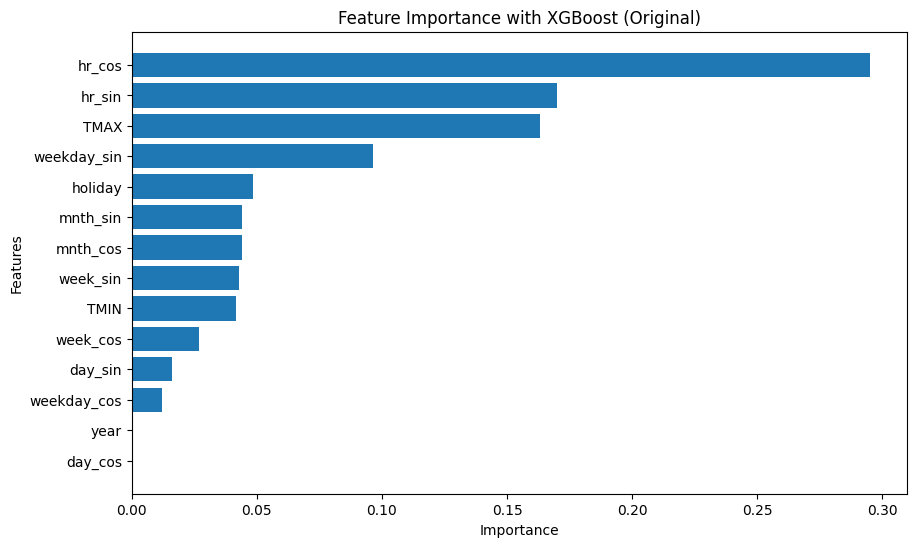

In [60]:
# Run the function without standardization
mse_no_scaling_v1, importance_no_scaling_v1 = run_xgboost_model(train_trips_modeling_feats, standardize=False)

In [61]:
importance_no_scaling_v1

,Feature,Importance
5,hr_cos,0.295054
4,hr_sin,0.169816
1,TMAX,0.163086
6,weekday_sin,0.096319
0,holiday,0.048622
10,mnth_sin,0.044148
11,mnth_cos,0.043883
8,week_sin,0.042769
2,TMIN,0.041592
9,week_cos,0.026837


In [62]:
mse_no_scaling_v1

432087.625

Mean Squared Error (MSE): 420261.4375


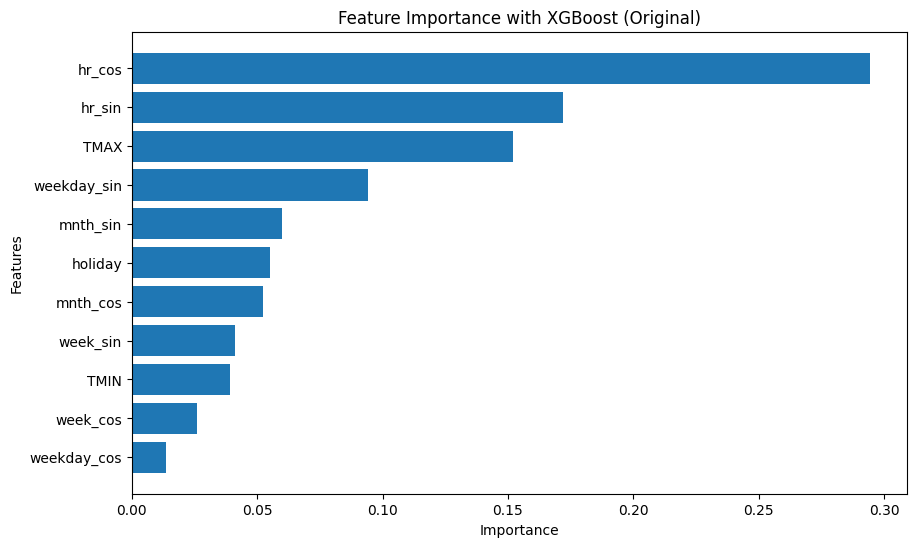

In [63]:
# Run the function without standardization
drop_cols_v2= ["year", "day_cos", "day_sin"]
#drop_cols_v2= ["year", "day_cos"]
mse_no_scaling_v2, importance_no_scaling_v2 = run_xgboost_model(train_trips_modeling_feats.drop(columns=drop_cols_v2), standardize=False)

In [64]:
importance_no_scaling_v2

,Feature,Importance
4,hr_cos,0.294361
3,hr_sin,0.172043
1,TMAX,0.151924
5,weekday_sin,0.094316
9,mnth_sin,0.059854
0,holiday,0.055093
10,mnth_cos,0.052366
7,week_sin,0.041268
2,TMIN,0.039058
8,week_cos,0.025906


In [65]:
mse_no_scaling_v2

420261.4375

In [66]:
mse_no_scaling_v1, mse_no_scaling_v2, (mse_no_scaling_v1 > mse_no_scaling_v2)

(432087.625, 420261.4375, True)

Mean Squared Error (MSE): 453142.3125


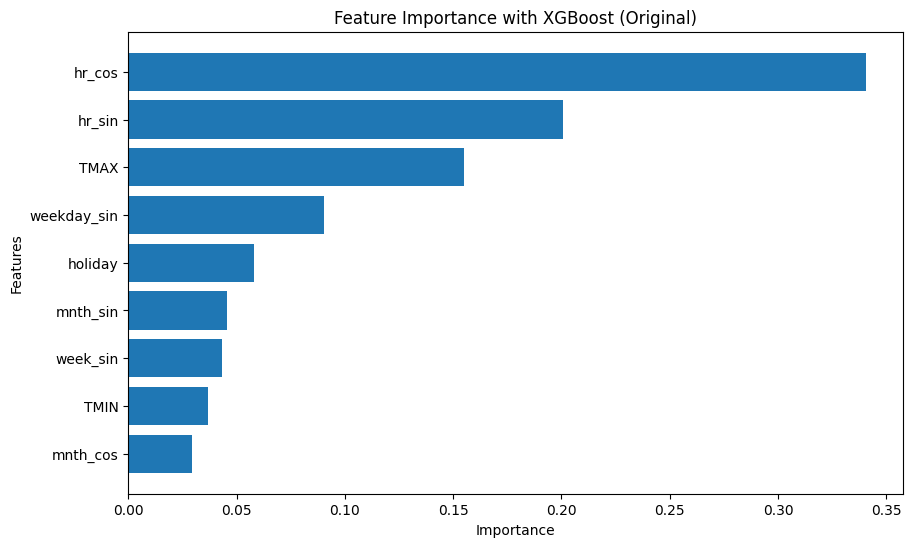

In [67]:
# Run the function without standardization
#drop_cols_v3 = drop_cols_v2 + ["weekday_cos"]
drop_cols_v3 = drop_cols_v2 + ["weekday_cos", "week_cos"]
mse_no_scaling_v3, importance_no_scaling_v3 = run_xgboost_model(train_trips_modeling_feats.drop(columns=drop_cols_v3), standardize=False)

In [68]:
importance_no_scaling_v3

,Feature,Importance
4,hr_cos,0.340797
3,hr_sin,0.200880
1,TMAX,0.155005
5,weekday_sin,0.090589
0,holiday,0.057842
7,mnth_sin,0.045595
6,week_sin,0.043198
2,TMIN,0.036638
8,mnth_cos,0.029456


In [69]:
mse_no_scaling_v3

453142.3125

In [70]:
mse_no_scaling_v1, mse_no_scaling_v2, mse_no_scaling_v3, (mse_no_scaling_v1 > mse_no_scaling_v3)

(432087.625, 420261.4375, 453142.3125, False)

## Select Features

In [71]:
# Target columns
target_column = "trips"

# Drop columns
drop_cols = ["year", "day_cos", "day_sin"]

# All features
all_features = train_trips_modeling_feats.columns

# Filtering features
features = [feat for feat in all_features if feat not in drop_cols]
print(features)

['trips', 'holiday', 'TMAX', 'TMIN', 'hr_sin', 'hr_cos', 'weekday_sin', 'weekday_cos', 'week_sin', 'week_cos', 'mnth_sin', 'mnth_cos']


In [72]:
# Train trips selectiong featutes
train_trips_modeling = train_trips_modeling_feats[features]

In [73]:
train_trips_modeling.shape

(8794, 12)

In [74]:
train_trips_modeling.head(5)

,trips,holiday,TMAX,TMIN,hr_sin,hr_cos,weekday_sin,weekday_cos,week_sin,week_cos,mnth_sin,mnth_cos
0,1863,1,47.0,36.0,0.000000,1.000000,0.0,1.0,0.0,1.0,0.0,1.0
1,2291,1,47.0,36.0,0.258819,0.965926,0.0,1.0,0.0,1.0,0.0,1.0
2,1903,1,47.0,36.0,0.500000,0.866025,0.0,1.0,0.0,1.0,0.0,1.0
3,1081,1,47.0,36.0,0.707107,0.707107,0.0,1.0,0.0,1.0,0.0,1.0
4,636,1,47.0,36.0,0.866025,0.500000,0.0,1.0,0.0,1.0,0.0,1.0


In [75]:
# Test trips selectiong featutes
test_trips_modeling = test_trips_modeling_feats[features]

In [76]:
test_trips_modeling.shape

(2113, 12)

In [77]:
test_trips_modeling.head(5)

,trips,holiday,TMAX,TMIN,hr_sin,hr_cos,weekday_sin,weekday_cos,week_sin,week_cos,mnth_sin,mnth_cos
0,1585,1,52.0,40.0,0.000000,1.000000,0.974928,-0.222521,0.0,1.0,0.0,1.0
1,2682,1,52.0,40.0,0.258819,0.965926,0.974928,-0.222521,0.0,1.0,0.0,1.0
2,2263,1,52.0,40.0,0.500000,0.866025,0.974928,-0.222521,0.0,1.0,0.0,1.0
3,1326,1,52.0,40.0,0.707107,0.707107,0.974928,-0.222521,0.0,1.0,0.0,1.0
4,754,1,52.0,40.0,0.866025,0.500000,0.974928,-0.222521,0.0,1.0,0.0,1.0


In [78]:
FINAL_DATA_DIR="../s3/data/final"

# Training 


https://whattodevnow.medium.com/using-localstack-with-docker-compose-to-mock-aws-services-bb25a5b01d4b

https://freedium.cfd/https://medium.com/@saveriomazza/local-mlflow-runs-with-low-cost-aws-tracking-e84b843a3c1c


https://docs.localstack.cloud/aws/integrations/aws-native-tools/aws-cli/

https://dev.to/jakewitcher/using-env-files-for-environment-variables-in-python-applications-55a1

https://mlflow.org/docs/latest/ml/traditional-ml/xgboost/guide/

https://mlflow.org/docs/latest/ml/tracking/artifact-stores/

https://github.com/mlflow/mlflow/issues/9513




zenml:

In [106]:
MLFLOW_SERVER_HOST="localhost"
MLFLOW_SERVER_PORT="5000"
MDFLOW_SERVER_URL=f"http://{MLFLOW_SERVER_HOST}:{MLFLOW_SERVER_PORT}"
MDFLOW_SERVER_URL

'http://localhost:5000'

In [95]:
AWS_REGION="eu-west-1"
AWS_ACCESS_KEY_ID="test"
AWS_SECRET_ACCESS_KEY="test"
os.environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
os.environ["AWS_SECRET_ACCESS_KEY"] = AWS_SECRET_ACCESS_KEY
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://localhost:4566"

In [107]:
mlflow.set_tracking_uri(uri=MDFLOW_SERVER_URL)

## Train base model

In [92]:
def train_model(
    X: pd.DataFrame, y: 
    pd.Series, params: Dict,
    run_name: str = "base-xgb-model"
) -> Any:

    with mlflow.start_run(run_name=run_name):
        # Crea el modelo con hiperparámetros optimizados
        
        if not params:
            params = {}
            params['n_estimators']=100
            params['random_state']=42
        
        model = xgb.XGBRegressor(**params)
        model.fit(X, y)
    
        # Predicciones para inferir la firma
        y_pred = model.predict(X)
        
        signature = infer_signature(X, y_pred)
    
        # Ejemplo de input para inferencia
        input_example = X.sample(1)
    
        # Logging a MLflow (ZenML maneja el contexto)
        mlflow.log_params(params)
        mlflow.xgboost.log_model(
            #xgb_model=model.get_booster(),
            xgb_model=model,
            artifact_path="xgb-model",
            signature=signature,
            input_example=input_example,
            model_format="json",
        )
        
    return model

In [80]:
def evaluate_model(
    model,
    X: pd.DataFrame, y: pd.Series
):
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    
    metrics = {}
    metrics['R2_Score'] = r2
    metrics['MAE'] = mae
    metrics['MSE'] = mse
    metrics['RMSE'] = rmse
    
    metrics_df = pd.DataFrame([metrics])
                 
    return metrics_df

In [81]:
output_notebook()  # Si usas Jupyter

def plot_predictions(model, X: pd.DataFrame, y: pd.Series):
    y_pred = model.predict(X)
    
    '''
    x_vals = y[0:100].index
    y_actual = y[0:100].values
    y_predicted = y_pred[0:100]
    
    plt.rcParams.update({'figure.figsize': (15, 3)})
    fig, ax = plt.subplots()
    #sns.lineplot(data=y, x=y.index, y='trips')
    sns.lineplot(x=x_vals, y=y_actual)
    sns.lineplot(x=x_vals, y=y_predicted, color='r')
    plt.grid(linestyle='-', linewidth=0.3)
    legend_elements = [Line2D([0], [0], color='b', lw=4, label='Actual'),
                Line2D([0], [0], color='r', lw=4, label='Predicted')]
    plt.legend(handles=legend_elements)
    #ax.tick_params(axis='x', rotation=90)
    '''
    
    # Prepara los datos
    x_vals = np.array(range(len(y)))
    y_actual = y.values
    y_predicted = y_pred

    # Crear figura con herramientas de interacción
    p = figure(title="Actual vs Predicted", 
               x_axis_label='Index',
               y_axis_label='Value',
               width=1200,
               height=600,
               tools="pan,wheel_zoom,box_zoom,reset,save",
               toolbar_location='above')

    # Agrega las líneas
    actual_line = p.line(x_vals, y_actual, line_width=2, color='blue', legend_label="Actual")
    predicted_line = p.line(x_vals, y_predicted, line_width=2, color='red', legend_label="Predicted")

    p.legend.location = "top_left"
    p.legend.click_policy = "hide"  # permite ocultar líneas al hacer clic en la leyenda
    p.grid.grid_line_alpha = 0.3

    show(p)  # muestra la figura interactiva en Jupyter o navegador

Loading BokehJS ...

In [111]:
train_trips_modeling['holiday'].map({1: 'Yes', 0: 'No'})

0       Yes
1       Yes
2       Yes
3       Yes
4       Yes
       ... 
8789     No
8790     No
8791     No
8792     No
8793     No
Name: holiday, Length: 8794, dtype: object

In [82]:

X = train_trips_modeling.drop(columns=[target_column])  # Features
y = train_trips_modeling[target_column]  # Target

In [83]:
X.head(5)

,holiday,TMAX,TMIN,hr_sin,hr_cos,weekday_sin,weekday_cos,week_sin,week_cos,mnth_sin,mnth_cos
0,1,47.0,36.0,0.000000,1.000000,0.0,1.0,0.0,1.0,0.0,1.0
1,1,47.0,36.0,0.258819,0.965926,0.0,1.0,0.0,1.0,0.0,1.0
2,1,47.0,36.0,0.500000,0.866025,0.0,1.0,0.0,1.0,0.0,1.0
3,1,47.0,36.0,0.707107,0.707107,0.0,1.0,0.0,1.0,0.0,1.0
4,1,47.0,36.0,0.866025,0.500000,0.0,1.0,0.0,1.0,0.0,1.0


In [84]:

X_test = test_trips_modeling.drop(columns=[target_column])  # Features
y_test = test_trips_modeling[target_column]  # Target

In [85]:

# Split the dataset into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [86]:
X_train.head(5)

,holiday,TMAX,TMIN,hr_sin,hr_cos,weekday_sin,weekday_cos,week_sin,week_cos,mnth_sin,mnth_cos
2576,0,59.0,48.0,1.000000,6.123234e-17,0.974928,-0.222521,0.970942,-0.239316,1.000000e+00,6.123234e-17
4556,0,92.0,74.0,-0.707107,-7.071068e-01,0.000000,1.000000,-0.120537,-0.992709,1.224647e-16,-1.000000e+00
2471,0,63.0,54.0,-0.707107,7.071068e-01,-0.433884,-0.900969,0.992709,-0.120537,1.000000e+00,6.123234e-17
5385,0,82.0,70.0,0.707107,7.071068e-01,0.000000,1.000000,-0.663123,-0.748511,-5.000000e-01,-8.660254e-01
1747,0,60.0,44.0,-1.000000,-1.836970e-16,0.974928,-0.222521,0.935016,0.354605,8.660254e-01,5.000000e-01


In [87]:
pd.DataFrame(y_train)

,trips
2576,3198
4556,7798
2471,4058
5385,348
1747,11822
...,...
5734,9793
5191,2116
5390,10265
860,4650


In [88]:
base_params = {}
base_params['n_estimators']=100
base_params['random_state']=42

In [89]:
X_train.isna().sum()

holiday        0
TMAX           0
TMIN           0
hr_sin         0
hr_cos         0
weekday_sin    0
weekday_cos    0
week_sin       0
week_cos       0
mnth_sin       0
mnth_cos       0
dtype: int64

In [90]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7035 entries, 2576 to 7270
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   holiday      7035 non-null   int64  
 1   TMAX         7035 non-null   float64
 2   TMIN         7035 non-null   float64
 3   hr_sin       7035 non-null   float64
 4   hr_cos       7035 non-null   float64
 5   weekday_sin  7035 non-null   float64
 6   weekday_cos  7035 non-null   float64
 7   week_sin     7035 non-null   Float64
 8   week_cos     7035 non-null   Float64
 9   mnth_sin     7035 non-null   float64
 10  mnth_cos     7035 non-null   float64
dtypes: Float64(2), float64(8), int64(1)
memory usage: 673.3 KB


In [110]:
X_train.columns

Index(['holiday', 'TMAX', 'TMIN', 'hr_sin', 'hr_cos', 'weekday_sin',
       'weekday_cos', 'week_sin', 'week_cos', 'mnth_sin', 'mnth_cos'],
      dtype='object')

In [108]:
base_xgb_model = train_model(X_train, y_train, base_params, run_name="xbg-base-model")

/home/emmuzoo/mlops-zoomcamp-project-2025/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


🏃 View run xbg-base-model at: http://localhost:5000/#/experiments/0/runs/77b647c4b4c34b7b96ee288048770c06
🧪 View experiment at: http://localhost:5000/#/experiments/0


## Evaluation

In [116]:
base_val_metrics_df = evaluate_model(
    base_xgb_model,
    X_val, 
    y_val
)

In [117]:
base_val_metrics_df

,R2_Score,MAE,MSE,RMSE
0,0.974324,420.544342,420261.4375,648.275742


In [118]:
plot_predictions(base_xgb_model, X_val[-200:], y_val[-200:])

In [119]:
base_test_metrics_df = evaluate_model(
    base_xgb_model,
    X_test, 
    y_test
)

In [120]:
base_test_metrics_df

,R2_Score,MAE,MSE,RMSE
0,0.808483,806.046875,1456909.75,1207.025165


In [121]:
plot_predictions(base_xgb_model, X_test[-200:], y_test[-200:])

# HPO

In [122]:
def optimize_hpo(X: pd.DataFrame, y: pd.Series, n_trials: int = 50) -> Dict:
    def objective(trial):
        # Espacio de búsqueda de hiperparámetros
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 300),
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0, 1.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0, 1.0),
            "objective": "reg:squarederror",  # Para regresión
            "random_state": 42,
            "n_jobs": -1
        }

        model = xgb.XGBRegressor(**params)

        # Validación cruzada con RMSE negativo (porque scikit-learn lo invierte)
        cv = KFold(n_splits=3, shuffle=True, random_state=42)
        scores = cross_val_score(model, X, y, scoring="neg_root_mean_squared_error", cv=cv)
        return np.mean(scores)  # mayor = mejor

    # Maximiza el valor negativo del RMSE (menor RMSE)
    study = optuna.create_study(
        direction="maximize" # Direction of optimization. Set minimize for minimization and maximize for maximization.
    )
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_params
    best_params["objective"] = "reg:squarederror"  # asegurar que se mantenga

    return best_params

## Run HPO

In [123]:
%%time
best_params = optimize_hpo(X, y, n_trials=100)

[I 2025-07-25 18:20:32,242] A new study created in memory with name: no-name-a43f0b2a-dabf-4c47-9fee-20afd809b49e
[I 2025-07-25 18:20:33,264] Trial 0 finished with value: -807.5281778971354 and parameters: {'n_estimators': 106, 'max_depth': 6, 'learning_rate': 0.0860843111345956, 'subsample': 0.8570769014047303, 'colsample_bytree': 0.8674139470810616, 'reg_alpha': 0.9884673773487942, 'reg_lambda': 0.047735956789692}. Best is trial 0 with value: -807.5281778971354.
[I 2025-07-25 18:20:33,729] Trial 1 finished with value: -940.2134399414062 and parameters: {'n_estimators': 161, 'max_depth': 4, 'learning_rate': 0.12168185150427174, 'subsample': 0.8075426694692764, 'colsample_bytree': 0.8018939727257078, 'reg_alpha': 0.7167055010091191, 'reg_lambda': 0.682770541759184}. Best is trial 0 with value: -807.5281778971354.
[I 2025-07-25 18:20:35,525] Trial 2 finished with value: -2627.5655924479165 and parameters: {'n_estimators': 60, 'max_depth': 11, 'learning_rate': 0.01400793148378568, 'subsa

CPU times: user 22min 32s, sys: 20 s, total: 22min 52s
Wall time: 3min 9s


In [124]:
best_params

{'n_estimators': 249,
 'max_depth': 7,
 'learning_rate': 0.12840705632256563,
 'subsample': 0.6584651528829266,
 'colsample_bytree': 0.9634181558827929,
 'reg_alpha': 0.5371038866706583,
 'reg_lambda': 0.9594626036796321,
 'objective': 'reg:squarederror'}

## Train optimized model

In [137]:
best_params = {'n_estimators': 249,
 'max_depth': 7,
 'learning_rate': 0.12840705632256563,
 'subsample': 0.6584651528829266,
 'colsample_bytree': 0.9634181558827929,
 'reg_alpha': 0.5371038866706583,
 'reg_lambda': 0.9594626036796321,
 'objective': 'reg:squarederror'}

In [138]:
%%time
opt_xgb_model = train_model(X, y, best_params, run_name="opt-xgb-model")

/home/emmuzoo/mlops-zoomcamp-project-2025/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/home/emmuzoo/mlops-zoomcamp-project-2025/.venv/lib/python3.12/site-packages/xgboost/sklearn.py:1028: UserWarning: [18:24:32] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as def

🏃 View run opt-xgb-model at: http://localhost:5000/#/experiments/0/runs/67ed34851d53483ab743bbb7ede1a503
🧪 View experiment at: http://localhost:5000/#/experiments/0
CPU times: user 4.55 s, sys: 124 ms, total: 4.68 s
Wall time: 6.51 s


## Evaluation  optimized model

In [139]:
opt_val_metrics_df = evaluate_model(
    opt_xgb_model,
    X_val, 
    y_val
)

In [140]:
opt_val_metrics_df

,R2_Score,MAE,MSE,RMSE
0,0.996764,160.743851,52965.34375,230.142008


In [141]:
base_val_metrics_df

,R2_Score,MAE,MSE,RMSE,model,ds
0,0.974324,420.544342,420261.4375,648.275742,base_val_xgb,val


In [142]:
opt_test_metrics_df = evaluate_model(
    opt_xgb_model,
    X_test, 
    y_test
)

In [143]:
opt_test_metrics_df

,R2_Score,MAE,MSE,RMSE
0,0.818378,773.765747,1381637.125,1175.430613


In [144]:
base_test_metrics_df

,R2_Score,MAE,MSE,RMSE,model,ds
0,0.808483,806.046875,1456909.75,1207.025165,base_val_xgb,test


In [145]:
plot_predictions(opt_xgb_model, X_val[-200:], y_val[-200:])

In [150]:
plot_predictions(opt_xgb_model, X_val[-400:-200], y_val[-400:-200])

In [146]:

base_val_metrics_df['model'] = 'base_val_xgb'
base_val_metrics_df['ds'] = 'val'
base_test_metrics_df['model'] = 'base_val_xgb'
base_test_metrics_df['ds'] = 'test'
opt_val_metrics_df['model'] = 'opt_val_xgb'
opt_val_metrics_df['ds'] = 'val'
opt_test_metrics_df['model'] = 'opt_test_xgb'
opt_test_metrics_df['ds'] = 'test'

In [147]:
summary = pd.concat([base_val_metrics_df, base_test_metrics_df, opt_val_metrics_df, opt_test_metrics_df])

In [148]:
summary

,R2_Score,MAE,MSE,RMSE,model,ds
0,0.974324,420.544342,4.202614e+05,648.275742,base_val_xgb,val
0,0.808483,806.046875,1.456910e+06,1207.025165,base_val_xgb,test
0,0.996764,160.743851,5.296534e+04,230.142008,opt_val_xgb,val
0,0.818378,773.765747,1.381637e+06,1175.430613,opt_test_xgb,test


In [151]:
test_url = "http://localhost:4566/citibike-data/data/citibike/processed/2024-citibike-tripdata.parquet"

In [152]:
test_data = pd.read_parquet(test_url)

In [153]:
test_data.head(5)

,date,hour,trips,holiday
0,2023-12-31,23,278,0
1,2024-01-01,0,1863,1
2,2024-01-01,1,2291,1
3,2024-01-01,2,1903,1
4,2024-01-01,3,1081,1


In [156]:
pd.concat([X, X_test], ignore_index=True)

,holiday,TMAX,TMIN,hr_sin,hr_cos,weekday_sin,weekday_cos,week_sin,week_cos,mnth_sin,mnth_cos
0,1,47.0,36.0,0.000000,1.000000,0.0,1.0,0.0,1.0,0.000000,1.0
1,1,47.0,36.0,0.258819,0.965926,0.0,1.0,0.0,1.0,0.000000,1.0
2,1,47.0,36.0,0.500000,0.866025,0.0,1.0,0.0,1.0,0.000000,1.0
3,1,47.0,36.0,0.707107,0.707107,0.0,1.0,0.0,1.0,0.000000,1.0
4,1,47.0,36.0,0.866025,0.500000,0.0,1.0,0.0,1.0,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...
10902,0,70.0,44.0,-0.965926,0.258819,0.0,1.0,1.0,-0.0,0.866025,0.5
10903,0,70.0,44.0,-0.866025,0.500000,0.0,1.0,1.0,-0.0,0.866025,0.5
10904,0,70.0,44.0,-0.707107,0.707107,0.0,1.0,1.0,-0.0,0.866025,0.5
10905,0,70.0,44.0,-0.500000,0.866025,0.0,1.0,1.0,-0.0,0.866025,0.5


In [157]:
pd.concat([y, y_test], ignore_index=True)

0        1863
1        2291
2        1903
3        1081
4         636
         ... 
10902    5963
10903    4289
10904    1577
10905     532
10906     404
Name: trips, Length: 10907, dtype: int64

In [181]:
X_tmp = pd.concat([train_trips_modeling_data.drop(columns=["trips"]), test_trips_modeling_data.drop(columns=["trips"])], ignore_index=True)
y_tmp = pd.concat([train_trips_modeling_data["trips"], test_trips_modeling_data["trips"]], ignore_index=True)
X_1, X_2, y_1, y_2 = train_test_split(X_tmp, y_tmp, test_size=0.20, shuffle=False)

In [182]:
X_1.tail(10)

,date,hour,holiday,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN
8715,2024-12-28,17,0,2024-12-28,3.1,0.56,0.0,0.0,42.0,50.0,39.0
8716,2024-12-28,18,0,2024-12-28,3.1,0.56,0.0,0.0,42.0,50.0,39.0
8717,2024-12-28,19,0,2024-12-28,3.1,0.56,0.0,0.0,42.0,50.0,39.0
8718,2024-12-28,20,0,2024-12-28,3.1,0.56,0.0,0.0,42.0,50.0,39.0
8719,2024-12-28,21,0,2024-12-28,3.1,0.56,0.0,0.0,42.0,50.0,39.0
8720,2024-12-28,22,0,2024-12-28,3.1,0.56,0.0,0.0,42.0,50.0,39.0
8721,2024-12-28,23,0,2024-12-28,3.1,0.56,0.0,0.0,42.0,50.0,39.0
8722,2024-12-29,0,0,2024-12-29,10.1,0.22,0.0,0.0,50.0,60.0,45.0
8723,2024-12-29,1,0,2024-12-29,10.1,0.22,0.0,0.0,50.0,60.0,45.0
8724,2024-12-29,2,0,2024-12-29,10.1,0.22,0.0,0.0,50.0,60.0,45.0


In [183]:
X_2.head(10)

,date,hour,holiday,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN
8725,2024-12-29,3,0,2024-12-29,10.1,0.22,0.0,0.0,50.0,60.0,45.0
8726,2024-12-29,4,0,2024-12-29,10.1,0.22,0.0,0.0,50.0,60.0,45.0
8727,2024-12-29,5,0,2024-12-29,10.1,0.22,0.0,0.0,50.0,60.0,45.0
8728,2024-12-29,6,0,2024-12-29,10.1,0.22,0.0,0.0,50.0,60.0,45.0
8729,2024-12-29,7,0,2024-12-29,10.1,0.22,0.0,0.0,50.0,60.0,45.0
8730,2024-12-29,8,0,2024-12-29,10.1,0.22,0.0,0.0,50.0,60.0,45.0
8731,2024-12-29,9,0,2024-12-29,10.1,0.22,0.0,0.0,50.0,60.0,45.0
8732,2024-12-29,10,0,2024-12-29,10.1,0.22,0.0,0.0,50.0,60.0,45.0
8733,2024-12-29,11,0,2024-12-29,10.1,0.22,0.0,0.0,50.0,60.0,45.0
8734,2024-12-29,12,0,2024-12-29,10.1,0.22,0.0,0.0,50.0,60.0,45.0




python run.py --data_url  http://localhost:4566/citibike-data/data/citibike/processed/


In [184]:
!aws --endpoint-url=http://localhost:4566 s3 ls s3://citibike-data


An error occurred (NoSuchBucket) when calling the ListObjectsV2 operation: The specified bucket does not exist


In [6]:
MLFLOW_SERVER_HOST="localhost"
MLFLOW_SERVER_PORT="5000"
MDFLOW_SERVER_URL=f"http://{MLFLOW_SERVER_HOST}:{MLFLOW_SERVER_PORT}"
MDFLOW_SERVER_URL

'http://localhost:5000'

In [10]:
mlflow.set_tracking_uri(uri=MDFLOW_SERVER_URL)

In [66]:
from mlflow import MlflowClient
from mlflow.tracking import MlflowClient, artifact_utils


In [67]:
client = MlflowClient()

In [48]:
model_name = "xgb-citibike-reg-model"
model_version_alias_candidate = "candidate"
model_version_alias_champion = "champion"

In [30]:
client.get_latest_versions(registered_model_name)

/tmp/ipykernel_29788/2983435765.py:1: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.get_latest_versions(registered_model_name)


[<ModelVersion: aliases=['candidate'], creation_timestamp=1753558639062, current_stage='None', description='', last_updated_timestamp=1753558639062, name='xgb-citibike-reg-model', run_id='9462e7c6563043e8a9e7822daa17de8a', run_link='', source='mlflow-artifacts:/1/9462e7c6563043e8a9e7822daa17de8a/artifacts/model', status='READY', status_message=None, tags={}, user_id='', version='3'>]

In [56]:
model_info = client.get_model_version_by_alias(model_name, model_version_alias_candidate)
model_info

<ModelVersion: aliases=['candidate'], creation_timestamp=1753567739146, current_stage='None', description='', last_updated_timestamp=1753567739146, name='xgb-citibike-reg-model', run_id='f8b244e78c564364913096f78ce2b538', run_link='', source='mlflow-artifacts:/1/f8b244e78c564364913096f78ce2b538/artifacts/model', status='READY', status_message=None, tags={'stage': 'Staging'}, user_id='', version='5'>

In [57]:
model_info.version, model_info.run_id, model_info.tags

('5', 'f8b244e78c564364913096f78ce2b538', {'stage': 'Staging'})

In [46]:
model_info.source

'mlflow-artifacts:/1/9462e7c6563043e8a9e7822daa17de8a/artifacts/model'

In [59]:
model_info = client.get_model_version_by_alias(model_name, model_version_alias_champion)
model_info

<ModelVersion: aliases=['champion'], creation_timestamp=1753573324868, current_stage='None', description='', last_updated_timestamp=1753573324868, name='xgb-citibike-reg-model', run_id='28702bf6e6b44a1ca79f1443c1709126', run_link='', source='mlflow-artifacts:/1/28702bf6e6b44a1ca79f1443c1709126/artifacts/model', status='READY', status_message=None, tags={'stage': 'Production'}, user_id='', version='8'>

In [25]:
#candidate_model_version = client.get_registered_model(registered_model_name).latest_versions['challenger']
candidate_model_version = client.get_registered_model(registered_model_name)

In [39]:
candidate_model_version

<RegisteredModel: aliases={'candidate': '3'}, creation_timestamp=1753547109333, description='', last_updated_timestamp=1753558639062, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1753558639062, current_stage='None', description='', last_updated_timestamp=1753558639062, name='xgb-citibike-reg-model', run_id='9462e7c6563043e8a9e7822daa17de8a', run_link='', source='mlflow-artifacts:/1/9462e7c6563043e8a9e7822daa17de8a/artifacts/model', status='READY', status_message=None, tags={}, user_id='', version='3'>], name='xgb-citibike-reg-model', tags={}>

In [44]:
candidate_model_version.latest_versions[0].version

'3'

In [23]:
candidate_model_version.latest_versions

IndexError: list index out of range

In [18]:

# Recuperar las versiones de los modelos
production_model_version = client.get_registered_model(registered_model_name).latest_versions['champion']


TypeError: list indices must be integers or slices, not str

In [64]:
champion_model_version = client.get_model_version_by_alias(model_name, model_version_alias_champion)

In [65]:
champion_model_version

<ModelVersion: aliases=['champion'], creation_timestamp=1753573324868, current_stage='None', description='', last_updated_timestamp=1753573324868, name='xgb-citibike-reg-model', run_id='28702bf6e6b44a1ca79f1443c1709126', run_link='', source='mlflow-artifacts:/1/28702bf6e6b44a1ca79f1443c1709126/artifacts/model', status='READY', status_message=None, tags={'stage': 'Production'}, user_id='', version='8'>

In [70]:
mlflow_run_id = champion_model_version.run_id
model_name = champion_model_version.name
mlflow_run_id, model_name

('28702bf6e6b44a1ca79f1443c1709126', 'xgb-citibike-reg-model')

In [71]:
model_uri = artifact_utils.get_artifact_uri(
    run_id=mlflow_run_id, artifact_path=model_name
)

In [72]:
model_uri

'mlflow-artifacts:/1/28702bf6e6b44a1ca79f1443c1709126/artifacts/xgb-citibike-reg-model'